Add the package to the path.

In [1]:
import sys
sys.path.append("/home/ace07/Documents/GitHub/QICKIT")

Import `qickit` modules. For this demo, we will import the circuit instances.

In [11]:
from qickit.circuit import QiskitCircuit, PennylaneCircuit, CirqCircuit, TKETCircuit, CUDAQCircuit

We will also import some basic modules for angle calculations.

In [12]:
import numpy as np

### Circuits Demo : Creating and manipulating quantum circuits

This notebook is dedicated to the demonstration of how `qickit` can be used to create gate-based quantum circuits. In this notebook, we go over all of the currently available frameworks, and how our `Circuit` wrapper provides a consistent interface for accessing all of these frameworks.

Generally speaking, we can present the following pipeline for creating and running quantum circuits:
1) **Create a quantum circuit + add measurements :** This step basically defines our quantum program.
2) **Define Backend :** Quantum circuits can be run on either classical or quantum mechanical architectures using CPUs, GPUs, or QPUs (Quantum Processing Units). This effectively breaks the category of backends into two:
    - **Simulators :** These are classical architecture simulation software which approximately emulate how a QPU would behave.
        - **Ideal simulators :** These simulators do not take noise, or layout into consideration and simply compute the circuit using tensor network contractions.
        - **Noisy simulators :** These simulators aim to emulate the behavior of QPUs more closely, ranging from custom defined models where the user can choose the layout and define arbitrary noise, to real-world emulators which mimic how some of the currently existing QPUs work, i.e., IBM's `FakeProvider`.
    - **QPUs :** These are the true quantum hardware. These vary depending on the paradigm (neutral atom, superconducting, photonics, etc.), connectivity (the layout and connections between the physical qubits), and volume (the maximum number of qubits and circuit depth supported). These are only accessible through paid API tokens available on respective company websites. Keep in mind you can use certain supported QPUs with your token in `qickit`.
3) **Update circuit to match connectivity constraints + Optimize for depth :** Once the circuit is defined and a backend is chosen, we need to transpile the circuit to match the native gate set and connectivity constraints of the specified backend. QPUs often require users to transpile their circuits to updated circuits which would only use the supported gates by the hardware. Notable instance of this would be IBM Qiskit's `transpile` feature. Furthermore, we can optimize the circuit depth by removing redundant gates (i.e., two CXs in an uninterrupted sequence applied to the exact same qubits) and even use Reinforcement Learning (RL) models to further reduce the depth.
4) **Run circuit on backend :** Once the circuit is ready to be run, we can execute it on the specified backend. On simulators we have more freedom and can directly extract the statevector and unitary operator of the circuit. However, QPUs can only retrieve the counts of the circuit, which limits how you can directly extract these information.
5) **Extract results :** After running the circuit and extracting the results, we are done!

With `qickit`, you can mix and match different frameworks, different backends, different optimization methods, etc., to create the perfect pipeline for your applications without the need to learn and integrate many packages manually.

To create circuits using our circuit wrapper instances such as `QiskitCircuit` and `CirqCircuit`, you simply define an instance, and then use the same syntax as outlined in the documentation to create a circuit. With our wrappers, you can create circuits in any package using a single syntax, and actively convert to and back from different frameworks in our supported list, allowing you to get the best out of all the packages and use any backend you desire.

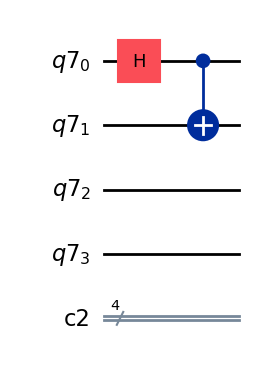

In [5]:
# Create a circuit
test_qc = QiskitCircuit(4)

# Apply a Hadamard gate to qubit 0
test_qc.H(0)
# Apply a CX gate to qubit 1 controlled by 0
test_qc.CX(0, 1)

# Draw the circuit
test_qc.circuit.draw('mpl')

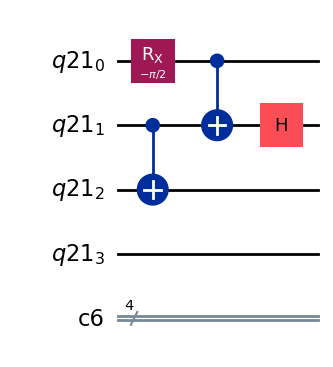

In [7]:
# Defining two circuits
test_qc1 = QiskitCircuit(4)
test_qc2 = QiskitCircuit(4)

# QC 1 provides a CX on qubits 1 and 2
test_qc1.CX(1, 2)

# QC 2 provides a Hadamard on qubit 1, and a CX on qubits 0 and 1
test_qc2.H(1)
test_qc2.CX(0, 1)
test_qc2.RX(np.pi/2, 0)

# We apply a horizontal_reverse, effectively switching the places for QC 2
test_qc2.horizontal_reverse(adjoint=True)

# We add the two circuits together
test_qc1.add(test_qc2, range(4))

test_qc1.circuit.draw('mpl')

### How to convert between the frameworks?

When converting to a different framework, you simply call the built-in method `.convert(other_framework)` allowing you to convert back and forth.

In [8]:
# Define a new circuit for the converted version
new_qc = test_qc1.convert(CirqCircuit)

new_qc.draw()

0: ───I───Rx(-0.5π)───@───────
                      │
1: ───@───────────────X───H───
      │
2: ───X───────────────────────


With existing intermediate frameworks like QASM 2.0, we also provide support for converting arbitrary frameworks to QASM 2.0 strings.

In [9]:
qasm_str = test_qc1.to_qasm()

qasm_str

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q21[4];\ncreg c6[4];\ncx q21[1],q21[2];\nrx(-pi/2) q21[0];\ncx q21[0],q21[1];\nh q21[1];'

#### How to run circuits?

When running the circuits, you can choose between the state vector or shots based measurement methods.

In [10]:
new_qc.get_statevector()

array([ 0.5+0.j ,  0. +0.5j,  0.5+0.j ,  0. -0.5j,  0. +0.j ,  0. +0.j ,
       -0. +0.j , -0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,
        0. +0.j ,  0. +0.j , -0. +0.j , -0. +0.j ])

In [13]:
new_qc.measure([3, 2, 1, 0])

new_qc.get_counts(1024)

{'0000': 256,
 '0001': 277,
 '0010': 238,
 '0011': 253,
 '0100': 0,
 '0101': 0,
 '0110': 0,
 '0111': 0,
 '1000': 0,
 '1001': 0,
 '1010': 0,
 '1011': 0,
 '1100': 0,
 '1101': 0,
 '1110': 0,
 '1111': 0}

#### How to optimize the circuits?

`qickit` provides two categories of optimization, which depending on the purpose of the optimization may be chosen. The first category consists of IBM Qiskit's transpilation engine, which provides a lossless decomposition into U3 and CX gates, and allows for mild optimization in the process. This is useful for circuit to hardware mappings, which require paying attention to the native gates supported by the hardware.

The second category consists of standalone optimization algorithms, which provide low-level optimization, i.e., reordering CX gates such that the total number of CX gates is minimized without any loss of fidelity. These algorithms provide further support on top of IBM Qiskit's transpilation engine, and function to provide the best performance for the user's algorithms.

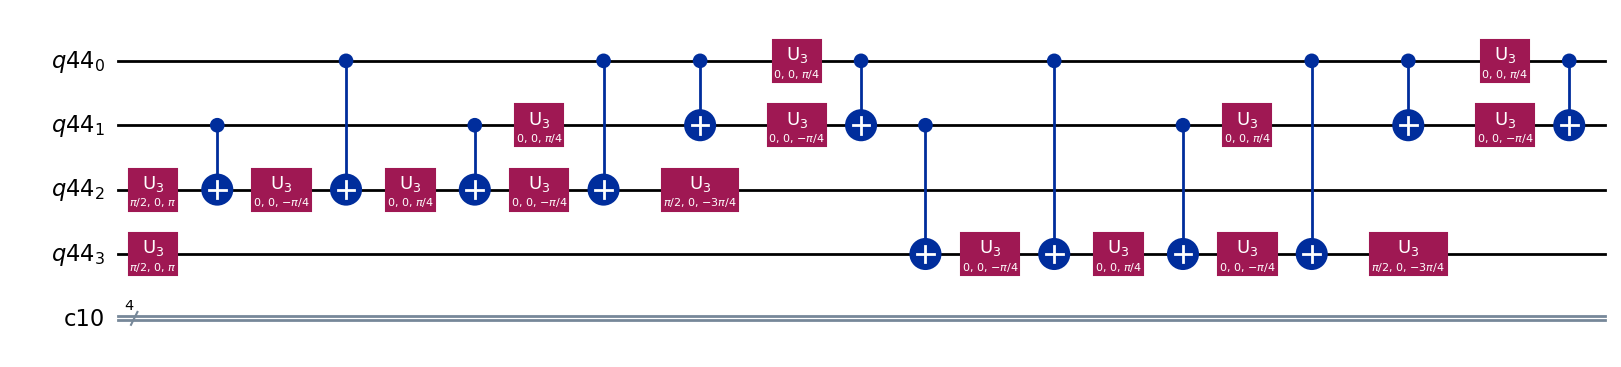

In [14]:
qc = QiskitCircuit(4)

qc.MCX([0, 1], [2, 3])

qc.transpile()

qc.circuit.draw('mpl')

Another application of IBM Qiskit's transpilation engine is for calculating the effective depth - the longest sequence of U3 and CX gates - of the circuit, which through `qickit`'s conversion framework, provides a consistent calculation of the depth of the circuit for all of the supported frameworks. This is particularly useful for applications where the algorithm benefits from depth estimation, and if not done properly, different frameworks will provide drastically different results given the definition of depth, i.e., number of operations regardless of decomposition (where a MCX gate for instance would be considered as two gates, instead of twenty one).

In [15]:
qc = TKETCircuit(4)

qc.MCX([0, 1], [2, 3])

print(qc.get_depth())

21


### How to perform non-unitary operators?

One of the main assets in quantum computing is the class non-unitary operations. These include use of mid-circuit measurement with classical conditions to enable long-range correlation, and error correction.

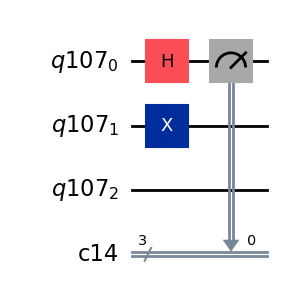

In [17]:
qc = QiskitCircuit(3)
qc.H(0)
if qc.clbit_condition(0, 0):
    qc.X(1)

qc.circuit.draw('mpl')

#### How to synthesize quantum states and operators?

You can synthesize quantum states using the built-in `qickit` state preparation algorithms. Below, we can see how to implement the Monty Hall problem using the state preparation algorithm.

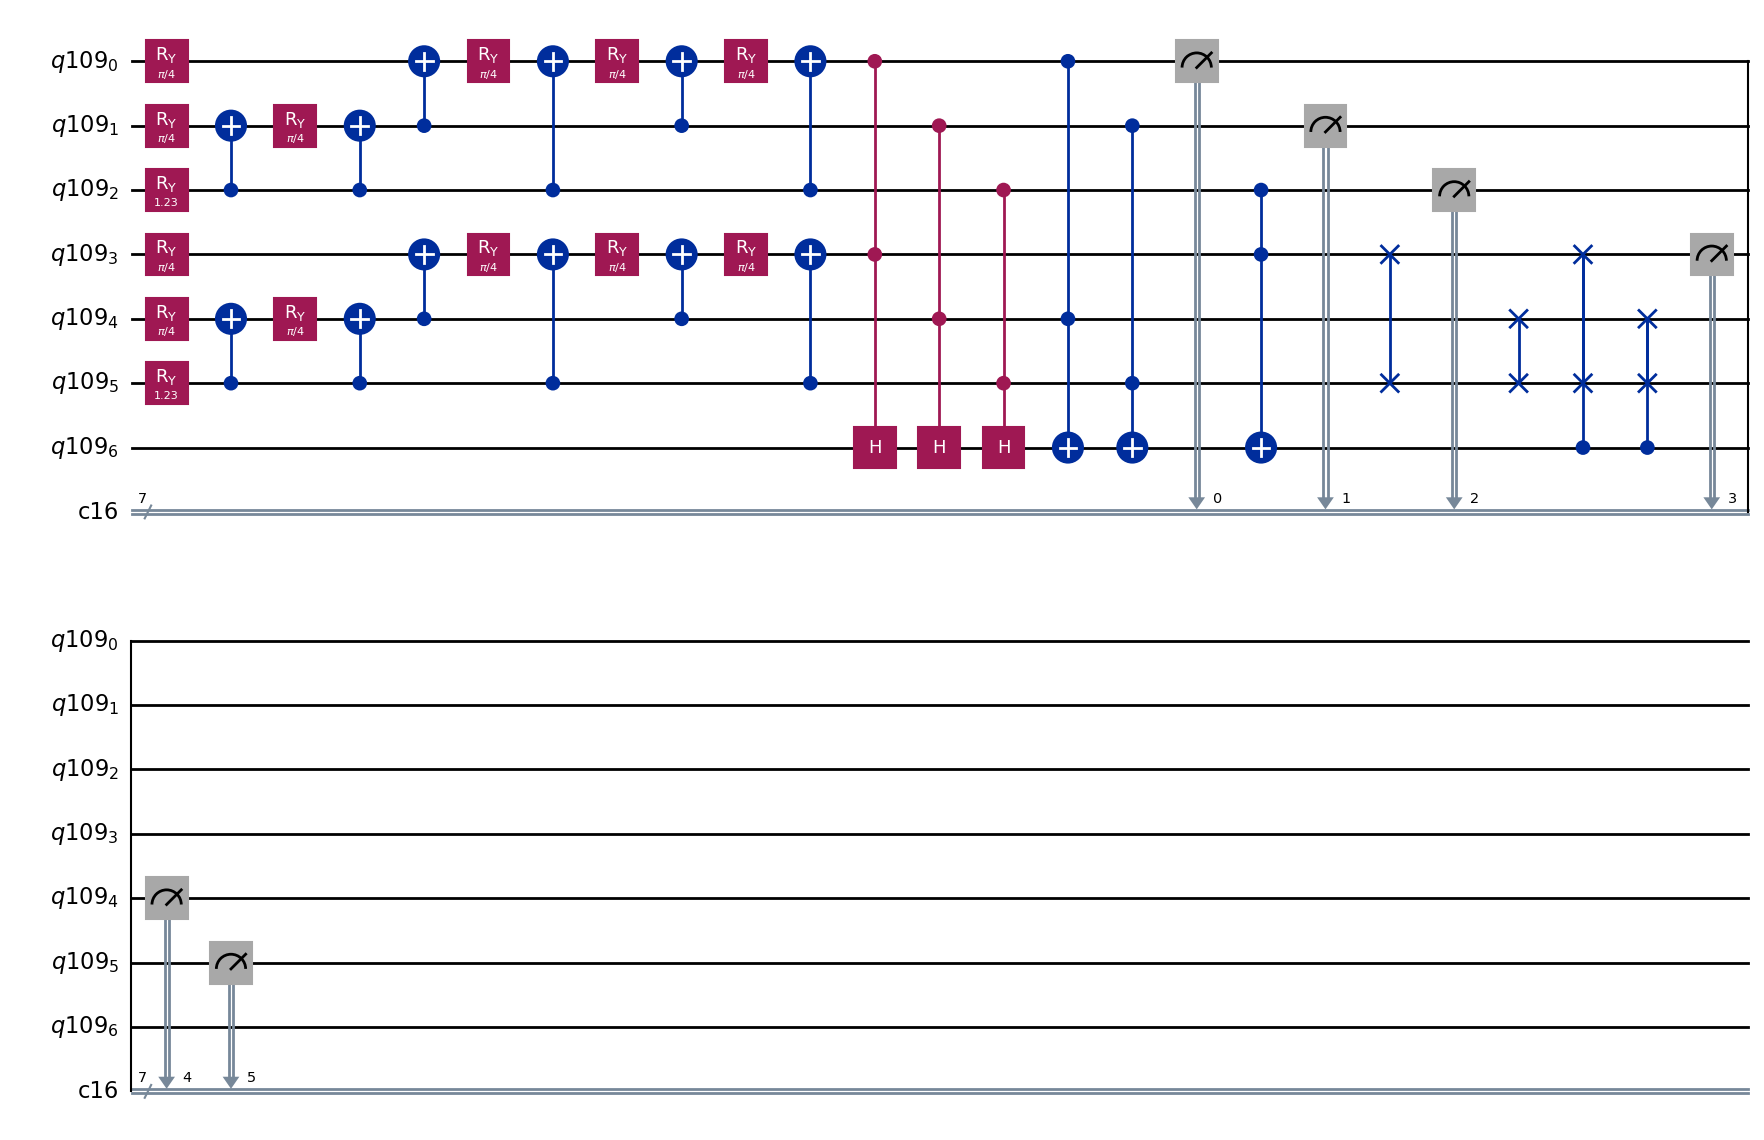

In [19]:
from qickit.synthesis.statepreparation import Mottonen


# Define the circuit
circuit = QiskitCircuit(7)

# Define the Monty Hall state
state = np.array([0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 1/np.sqrt(3), 0, 0, 0])

# Define the circuit that prepares the Monty Hall state
encoder = Mottonen(QiskitCircuit)
encoded_circuit = encoder.prepare_state(state=state, compression_percentage=0, index_type='row')

# Add the two circuits to prepare the doors and choices states
circuit.add(encoded_circuit, [0, 1, 2])
circuit.add(encoded_circuit, [3, 4, 5])

# Add the circuit for Monty Hall's host
circuit.MCH([0, 3], 6)
circuit.MCH([1, 4], 6)
circuit.MCH([2, 5], 6)

circuit.MCX([0, 4], 6)
circuit.MCX([1, 5], 6)
circuit.MCX([2, 3], 6)

circuit.SWAP(3, 5)
circuit.SWAP(4, 5)
circuit.CSWAP(6, 3, 5)
circuit.CSWAP(6, 4, 5)

circuit.measure(range(6))

circuit.circuit.draw('mpl')

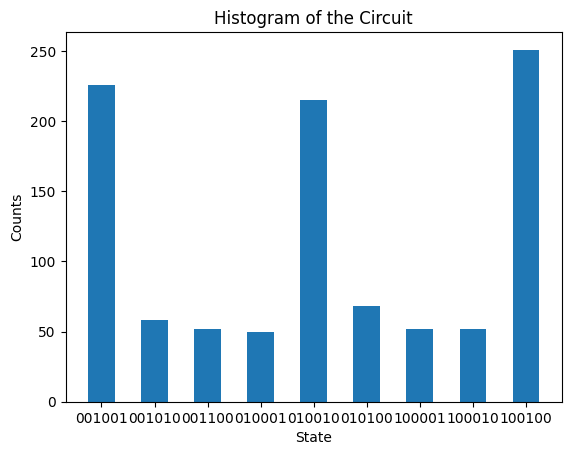

In [20]:
plot = circuit.plot_histogram(True)
plot

<BarContainer object of 2 artists>

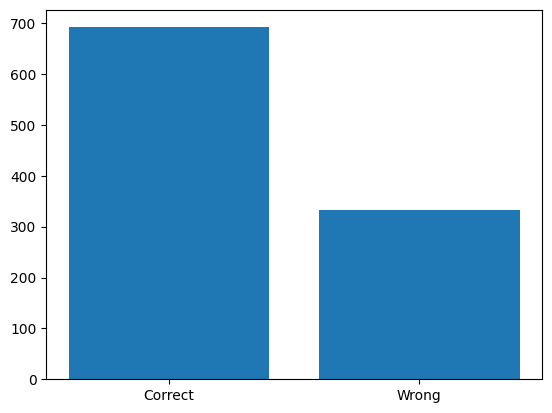

In [21]:
import matplotlib.pyplot as plt

counts = circuit.get_counts(1024)
counts = {key: value for key, value in counts.items() if value != 0}

num_correct = 0
num_wrong = 0
correct_ans = ['001001', '010010', '100100']

for i in counts.keys():
    if str(i) in correct_ans:
        num_correct += counts[i]
    else:
        num_wrong += counts[i]

plt.bar(['Correct', 'Wrong'], [num_correct, num_wrong])

`qickit` provides many built-in features which make development as seamless as possible. With the wrapper approach, you reach a hardware agnostic implementation. However, since the wrapper supports almost all currently existing frameworks, you can access any backend through any framework without having to change syntax or your application.

`qickit` as of 2024 is still in the early stages of development, therefore there will be many more features such as further built-in optimizations, transpliations, and more backends available as it evolves.

<p>© 2024 Qualition Computing, all rights reserved.</p>